In [47]:

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
import numpy as np
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split


digits = datasets.load_digits()
target = digits.target

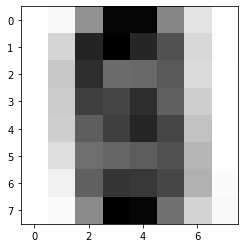

In [48]:
#(a) Plot a picture of the mean vector.
mean = sum(digits.images)/digits.images.shape[0]
plt.imshow(mean, cmap=plt.cm.gray_r)
plt.show()

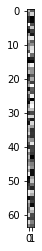

In [49]:
#(b) For EM, plot a picture of the initial values of each column of factor loading matrix and the
#final values as well.
mu = mean.flatten()
N = digits.images.shape[0]
D = digits.images.shape[1]*digits.images.shape[2]
H = 2

Images = np.zeros((D, N))
for i in range(N):
    Images[:, i] = digits.images[i].flatten() - mu

#initalize the loading matrix and plot(max=1, min=0)
W = np.random.uniform(0,1,(D,H))
plt.imshow(W, cmap=plt.cm.gray_r)
plt.show()

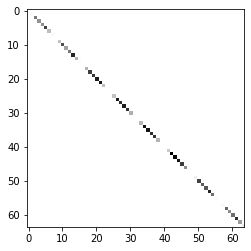

In [50]:
#(c) Plot a picture of the diagonal elements of noise variance.
Var = np.zeros(D)
for i in range(D):
    Var[i] = np.var(Images[i, :])
    if Var[i] == 0:
        Var[i] = 0.01


#initalize diagonal elements of noise variance
Psi = np.diag(Var)
plt.imshow(Psi, cmap=plt.cm.gray_r)
plt.show()

-48233.16612611367
-23624.358852199533
-16569.02712686203
-13918.043126215693
-12853.537790246544
-12406.515906599212
-12219.057484010274
-12049.095702358907
-11914.296436436249
-11872.28833832858


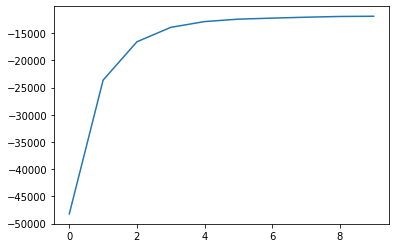

In [51]:
#(d) Plot the trajectory of the average log likelihood for each step until convergence or termination
#or the best parameter.

#Calculate the expectation of z|x
def Expect_z_x(W, Psi, x):
    Psi_inv= np.linalg.pinv(Psi)
    return np.dot(np.linalg.pinv((np.identity(H) + np.dot(np.dot(W.T,Psi_inv), W))), np.dot(np.dot(W.T, Psi_inv), x))


#calculate z from X = Wz + eplison
def Update_z(W, Psi, X):
    Z = np.zeros((X.shape[1],H))
    for i in range(X.shape[1]):
        Z[i, :] = np.dot(np.linalg.pinv(W), X[:, i] - np.random.multivariate_normal(np.zeros(D), Psi).T)
    return Z

#calculate the log-likelihood function
def Loglikelihood(W, Psi, X):
    l=0
    Z = Update_z(W, Psi, X)
    for i in range(X.shape[1]):
        l += np.dot(np.dot((X[:, i]-np.dot(W, Z[i, :])).T,np.linalg.pinv(Psi)), (X[:, i]-np.dot(W, Z[i, :]))) + np.dot(Z[i, :].T, Z[i, :])
    l *= -0.5
    l -= X.shape[1]/2*(np.log(np.linalg.det(Psi))-np.log(H))-X.shape[1]*D/2*np.log(2*np.pi)
    return l

#Iteration for W
def Iteration_W(W, Psi, X):
    temp1 = np.zeros((D, H))
    temp2 = np.zeros((H, H))
    for i in range(X.shape[1]):
        Ez_x = Expect_z_x(W, Psi, X[:, i]).reshape(H,-1)
        temp1 += np.dot(X[:, i].reshape(D,-1), Ez_x.T)
        temp2 += np.dot(Ez_x, Ez_x.T)
    return np.dot(temp1, np.linalg.inv(temp2))

#Iteration for Phi
def Iteration_Psi(W, Psi, X):
    temp = [0.01]*64
    temp = np.diag(temp)
    for i in range(X.shape[1]):
        Ez_x = Expect_z_x(W, Psi, X[:, i])
        temp += np.dot(X[:, i].reshape(D,-1), X[:,i].reshape(D,-1).T) + np.dot(W, np.dot(Ez_x.reshape(H,1), X[:,i].reshape(D,-1).T))
    return np.diag(np.diag(temp))/N


def SplitData(X, target, size):
    Index = np.arange(0,N)
    train_in, test_in = train_test_split(Index, test_size=size, random_state=42)
    train = Images[:, train_in]
    test = Images[:, test_in]
    target_train = target[train_in]
    target_test = target[test_in]
    return train, test, target_train, target_test

def DoIteration(W_t, Psi_t, X):
    l = []
    l_old = 0
    l_new = 500

    # using the algorithm 12.41
    while abs((l_new - l_old) / l_new) > 0.01:
        l_old = l_new
        W_t = Iteration_W(W_t, Psi_t, X)
        Psi_t = Iteration_Psi(W_t, Psi_t, X)
        l_new = Loglikelihood(W_t, Psi_t, X)
        l.append(l_new.real)
        print(l_new.real)
    return l, W_t, Psi_t


train_set, test_set, target_train, target_test = SplitData(Images, target, 0.8)
l, W, Psi = DoIteration(W, Psi, train_set)
plt.plot(l)
plt.show()

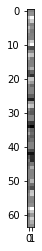

In [54]:
#(b) For EM, plot a picture of the initial values of each column of factor loading matrix and the
#final values as well.
plt.imshow(W, cmap=plt.cm.gray_r)
plt.show()

In [52]:
#(e) Calculate the average log likelihood the data
ll_train = Loglikelihood(W, Psi, train_set)
ll_test = Loglikelihood(W, Psi, test_set)
print("Training set :", ll_train)
print("Testing set :", ll_test)


Training set : -11884.027334582024
Testing set : -362127.8604979651


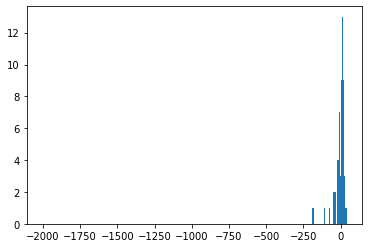

In [60]:
#(f) Histogram of the log likelihoods of the training case and test case
def Loglikelihood_list(W, Psi, X):
    l_list = []
    l = 0
    Z = Update_z(W, Psi, X)
    for i in range(X.shape[1]):
        l = -0.5 * np.dot(np.dot((X[:, i]-np.dot(W, Z[i, :])).T,np.linalg.pinv(Psi)), (X[:, i]-np.dot(W, Z[i, :]))) + np.dot(Z[i, :].T, Z[i, :])
        l -= 1/2*(np.log(np.linalg.det(Psi))-np.log(H))-D/2*np.log(2*np.pi)
        l_list.append(l)
    return l_list

l_list = Loglikelihood_list(W, Psi, train_set)
plt.hist(l_list, bins=2000)
plt.show()


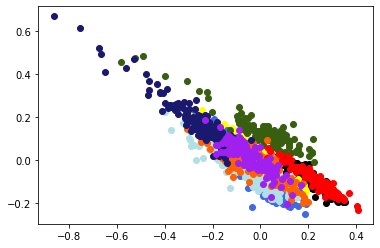

In [53]:
#(e) 2D scatter plot ( z 1 ,z 2 ) by computing the posterior mean of each point p ( z|x )


Z = np.zeros((test_set.shape[1], 2))
for i in range(test_set.shape[1]):
    Z[i, :] = Expect_z_x(W, Psi, test_set[:, i])


    
colors = ['#000000', '#FFFF00', '#4169E1', '#B0E0E6', '#385E0F', '#FF6100', '#FF0000', '#191970', '#A020F0', '#7FFF00']
for i in range(9):
    plt.scatter(Z[target_test == i,0], Z[target_test == i, 1], c = colors[i])
plt.show()

In [55]:
#(h) Show the sample data with the smallest, median and largest posterior values on both z 1 and z 2
z1_smallest = np.min(Z[:, 0])
z1_median = np.median(Z[:, 0])
z1_largest = np.max(Z[:, 0])
z2_smallest = np.min(Z[:, 1])
z2_median = np.median(Z[:, 1])
z2_largest = np.max(Z[:, 1])
print("smallest z1 : ", z1_smallest)
print("median z1 : ", z1_median)
print("largest z1 : ", z1_largest)
print("smallest z2 : ", z2_smallest)
print("median z2 : ", z2_median)
print("largest z2 : ", z2_largest)

smallest z1 :  -0.8639799144335639
median z1 :  0.012365286258682495
largest z1 :  0.407558436442694
smallest z2 :  -0.2508967206207578
median z2 :  -0.023467697034604926
largest z2 :  0.6697216547318279
